<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/JustWickU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# import required libraries
import pymc as pm # for model
import pandas as pd # for managing data
# for plots
import arviz as az
import seaborn as sns

# NBA Total Rebounds

I will be using the NBA player data provided for this project. Specifically, I will be trying to model total rebounds for each position.

First, I will read the basketball data from the provided csv file and convert it to a a Pandas dataframe. Then, I remove all columns except Pos (position) and TRB (total rebounds) because those are all the model is interested in.

In [43]:
url = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
basketball_data = pd.read_csv(url,dtype={'Pos':'category'})
basketball_data = basketball_data[["Pos", "TRB"]]
pos_idx = basketball_data.Pos.cat.codes.values
pos_codes = basketball_data.Pos.cat.categories
basketball_coords = {"pos": pos_codes}
basketball_data

,Pos,TRB
0,PF-C,487
1,C,737
2,SG,216
3,PF,352
4,SG,167
...,...,...
567,PF,103
568,PG,149
569,C,208
570,C,112


Now that I have the data in a dataframe, I am going to plot it to see how the data is distributed.

<Axes: ylabel='TRB'>

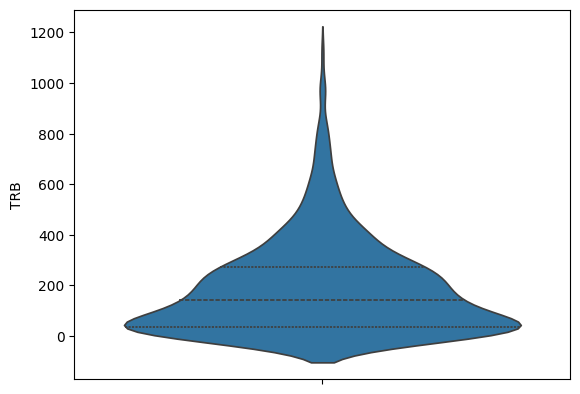

In [44]:
sns.violinplot(basketball_data.TRB,inner='quart')

This data looks roughly like a normal distribution. Therefore, I will use a normal prior and normal and half-normal hyperpriors because I think the data is likely close to reality, so I want the prior to match the data closely. Also, because there are so many players, the prior won't matter that much because the data will overwhelm it.

Output()

Output()

ERROR:pymc.stats.convergence:There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

<Axes: xlabel='gs'>

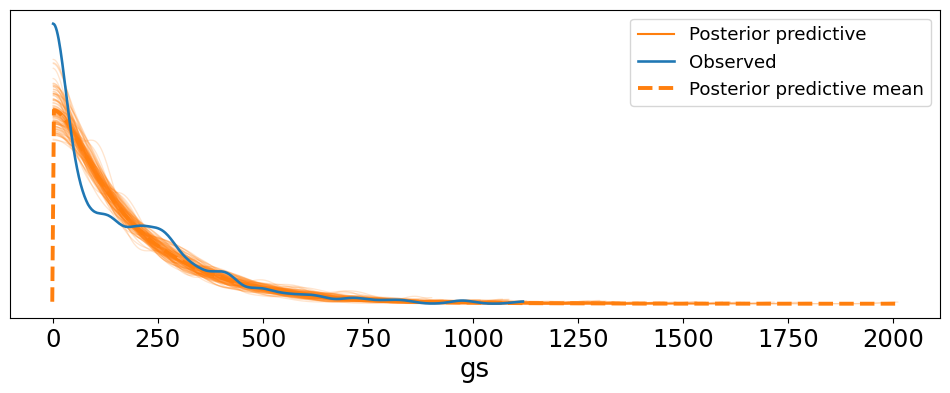

In [45]:
with pm.Model(coords = basketball_coords) as basketball_model:
    # Hyper parameters
    μ = pm.Normal('μ', mu = 60, sigma = 100)
    ν = pm.HalfNormal('ν', sigma = 100)


    # Parameters for positions
    μ_p = pm.Normal('μ_p', mu = μ, sigma = ν)

    _ = pm.Exponential('gs', lam = 1/μ_p, observed = basketball_data.TRB.values)

    data_basketball = pm.sample(target_accept = 0.99)

pm.sample_posterior_predictive(data_basketball, model=basketball_model, extend_inferencedata=True) # sample from the posterior predictve
az.plot_ppc(data_basketball, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]) # plot result

This model isn't perfect, but I think it's close enough to proceed. It has a relatively low number of divergences and is the best I could get by changing the paramemters, so I will now move on to splitting it up by positions.

In [46]:
with pm.Model(coords = basketball_coords) as basketball_model:
    # Hyper parameters
    μ = pm.Normal('μ', mu = 60, sigma = 100)
    ν = pm.HalfNormal('ν', sigma = 100)


    # Parameters for positions
    μ_p = pm.Normal('μ_p', mu = μ, sigma = ν, dims="pos")

    _ = pm.Exponential('gs', lam = 1/(μ_p[pos_idx]), observed = basketball_data.TRB.values)

    hierarchical_data_basketball = pm.sample(target_accept = 0.99)

Output()

Output()

In [47]:
az.rhat(hierarchical_data_basketball)

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    μ        float64 8B 1.001
    μ_p      (pos) float64 96B 1.001 0.9996 0.9996 1.001 ... 1.001 0.9999 1.0
    ν        float64 8B 1.0

Because the model has no divergences and the rhat values for the all the positions are very close to 1, I think it is quite good. However, I will also run plot trace to judge it further.

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

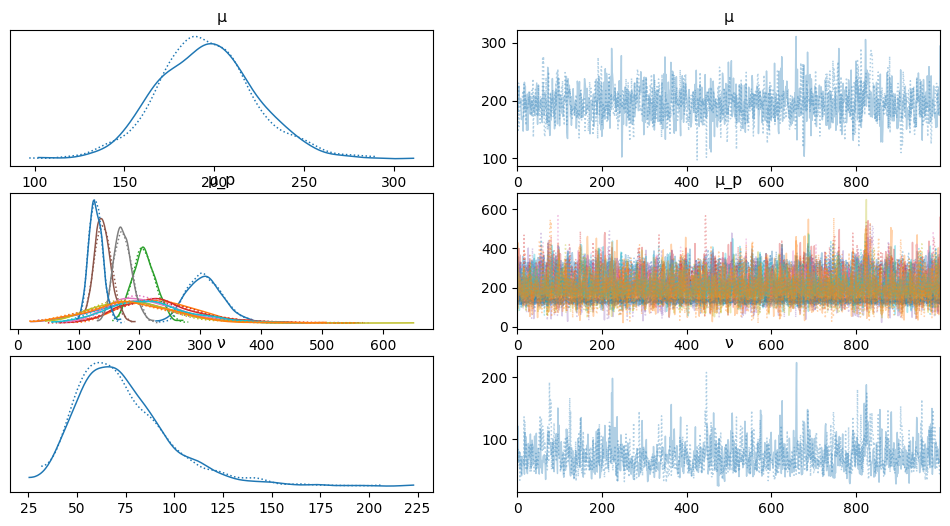

In [48]:
az.plot_trace(hierarchical_data_basketball)

The plot trace also suggests a quite accurate model because the dotted and solid curves are close to each other.

array([<Axes: >], dtype=object)

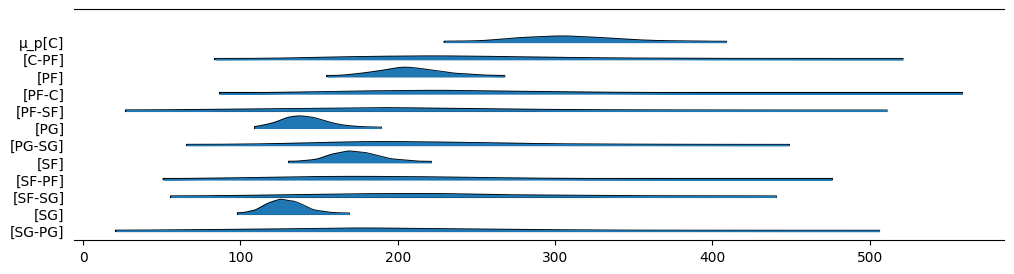

In [49]:
az.plot_forest(hierarchical_data_basketball, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

This plot shows that the model is more confident about some positions than others. For example, the distributions for point guards, shooting forward, and shooting guard are narrower than the rest of them. Additionally, we can see that the mean is different for different positions, which suggests that having a hierarchical model helped by allowing the model to differentiate between the different positions.